# Remove Redundant Data

In [88]:
import pandas as pd

# Reading a CSV file into a DataFrame, selecting specific columns
fields = ['item_description']
df = pd.read_csv('order_details_202505141508.csv', usecols=fields)

# use for loop to print first 10 rows of the DataFrame
for i in range(20):
    print(df.iloc[i].values[0])

Place Packing List Inside Box and Stamp Box
5 PIECES PER POLYBAG
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
50 EACH OF ITEM COLOR IN ONE BOX
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
APPLY BARCODE LABELS TO EACH ITEM
5 PER POLYBAG
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
Apply Fragile and Directional labels to all cartons.
Place Packing List Inside Box and Stamp Box
Special Package - POLYBAG ONE OF EACH COLOR
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box	
Place Packing List Inside Box and Stamp Box
3 OF THE FEMALE & 3 OF THE MALE PHYSICIAN IN ONE POLY BAG


In [89]:
print(df.shape)
print("\n\nAfter removing duplicates")
df['item_description'] = df['item_description'].str.lower() # there are lots of words with the same meaning but different cases
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)


for i in range(20):
    print(df.iloc[i].values[0])

# turn it into a list
item_list = df['item_description'].tolist()
print(len(item_list))

(34938, 1)


After removing duplicates
(34938, 1)
(3361, 1)
place packing list inside box and stamp box
5 pieces per polybag
50 each of item color in one box
apply barcode labels to each item
5 per polybag
apply fragile and directional labels to all cartons.
special package - polybag one of each color
place packing list inside box and stamp box	
3 of the female & 3 of the male physician in one poly bag
5 item per poly bag
boxes of 100
special package - 100 per box
special package 25 per polybag
10 per polybag
packages of 25
yellow msb.com labels to outside of all shipping cartons
1 box assorted items
attach nfl hologram sticker
special package - packs of 25
140 of each color per box
3361


UMAP is often preferred for larger datasets or when maintaining both global and local patterns is crucial, while t-SNE might be used for finer cluster analysis in smaller datasets. PCA is generally faster and preferred for preliminary analysis or when the relationships in the data are primarily linear.

Try UMAP first
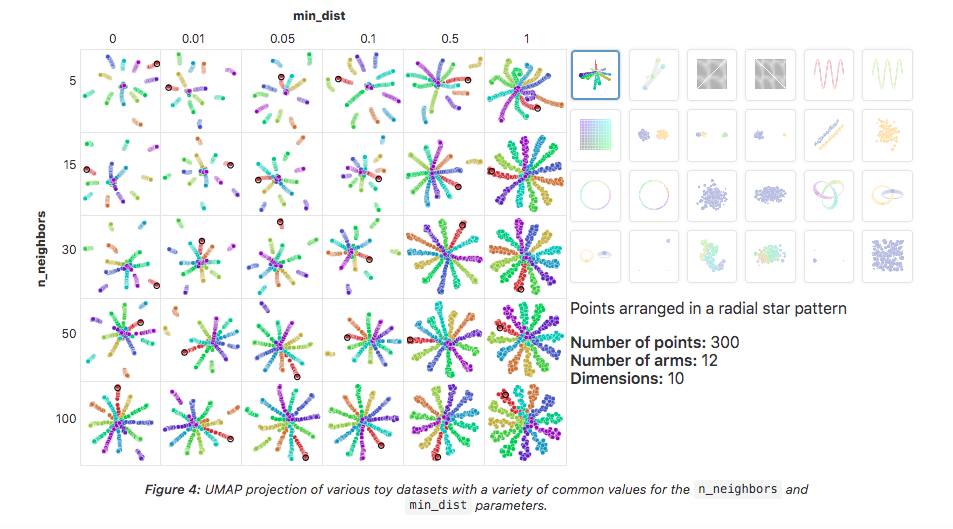

In [93]:
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt

# load the model
model = SentenceTransformer('all-MiniLM-L6-v2')
# encode the sentences
embeddings = model.encode(item_list, show_progress_bar=True)

# reduce the dimensionality of the embeddings. 
# n_neighbors is the number of neighbors to consider when constructing the UMAP graph. For noisy data, larger n_neighbors may produce more stable embeddings.
# n_components is the number of dimensions to reduce to(output dimension). Use 2 for visulization purposes, try 5 later!
reducer = umap.UMAP(n_neighbors=200, n_components=200, metric='cosine')
embeddings = reducer.fit_transform(embeddings)



Batches:   0%|          | 0/106 [00:00<?, ?it/s]

In [ ]:
# clustering the reduced embeddings
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean') # for min_cluster_size, Smaller → more (and smaller) clusters, Larger → fewer, more robust clusters

# fit the HDBSCAN model to the reduced embeddings
clusterer.fit(embeddings)
# get the cluster labels
labels = clusterer.labels_

In [106]:
import random
from collections import defaultdict

# for reproducibility
random.seed(42)  

# Create a dictionary to hold sentences by cluster
cluster_dict = defaultdict(list)

# Fill the dictionary
for label, sentence in zip(clusterer.labels_, item_list):
    cluster_dict[label].append(sentence)

# Display a few clusters
for label in sorted(cluster_dict.keys()):
    print(f"\n=== Cluster {label} ===")
    cluster = cluster_dict[label]

    # randomly select 5 sentences from the cluster
    sample_size = min(5, len(cluster))
    sample = random.sample(cluster, sample_size) 
    
    for sentence in sample:
        print(f"'{sentence}'")
    if len(cluster) > 5:
        print(f"...and {len(cluster) - 5} more\n")


=== Cluster -1 ===
'redo due to acourier issue - pieces broke in transit'
'individual package'
'special package - 100 per carton'
'box 2 13 pieces for bjc'
'1 of each item in box'
...and 725 more


=== Cluster 0 ===
'special package - core 365 jackets see spreadsheet female medium'
'special package - core 365 jackets see spreadsheet male xl'
'special package - core 365 jackets see spreadsheet for sizes '
'special package - core 365 jackets see spreadsheet female small'
'special package - core 365 jackets see spreadsheet male medium'
...and 7 more


=== Cluster 1 ===
'print bi-lingual instructions on polybag - wpc-hs20wh'
'print bi-lingual instructions on polybag - chaperon masks'
'print bi-lingual instructions on polybag'
'print bi-lingual instructions on polybag - wpc-hs20lg'
'print bi-lingual instructions on polybag - wpc-hq15wh'
...and 12 more


=== Cluster 2 ===
'insert bi-lingual instruction card - c2 whf-sq15pu'
'insert bi-lingual instruction card - whf-cw18bk'
'insert bi-lingua

c:\Users\AlanC\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


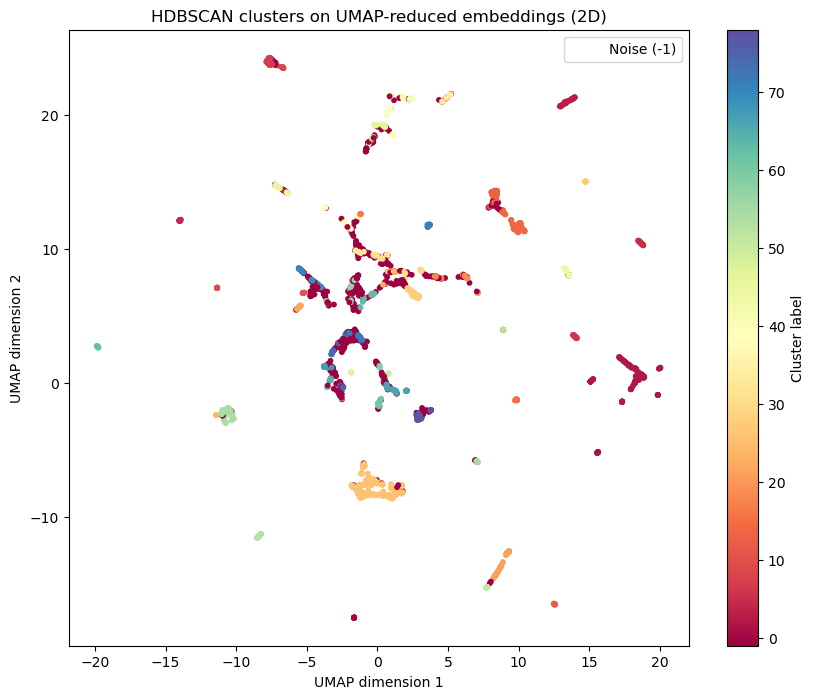

In [99]:
import umap
import matplotlib.pyplot as plt

# 1. Re‑embed into 2D for visualization
reducer_2d = umap.UMAP(
    n_neighbors=30,
    n_components=2,
    metric='cosine',
    random_state=42
)
embeds_2d = reducer_2d.fit_transform(embeddings)  # embeddings from your SentenceTransformer step

# 2. Scatter‑plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeds_2d[:, 0],
    embeds_2d[:, 1],
    c=labels,                  # labels from HDBSCAN
    cmap='Spectral',           # nice categorical palette
    s=10,                       # point size
    alpha=1                  # make overlaps visible
)
plt.colorbar(scatter, label='Cluster label')
plt.title('HDBSCAN clusters on UMAP-reduced embeddings (2D)')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')

# 3. Optional: highlight noise points
noise_mask = labels == -1
plt.scatter(
    embeds_2d[noise_mask, 0],
    embeds_2d[noise_mask, 1],
    # show noise points in transparent
    alpha=0, # comment out to see them
    c='black',
    s=1,
    label='Noise (-1)'
)
plt.legend(markerscale=2, frameon=True)
plt.show()


In [67]:
# Display the first 10 rows of specific clusters

print(sorted(cluster_dict.keys()))

# label = -1 #Noise
label = 1 #Cluster number
print(f"\n=== Cluster {label} ===")
for sentence in cluster_dict[label][:20]:  # Show only first 10 per cluster
    print(f"• {sentence}")
if len(cluster_dict[label]) > 20:
    print(f"...and {len(cluster_dict[label]) - 20} more\n")

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

=== Cluster 1 ===
• apply correct ingredients labels
• add ingredient label
• add ingredients label
• apply qr code label for canadian ingredient label
• apply qr code label for canadian ingredient label 
• adhere qr code label for canadian ingredient label
• apply qr code for canadian ingredient label
• adhere qr code to wsa-gm20 for canada shipping
• use canadian label template
• apply qr code label for canadian ingreident label
• canadian ingredient label required.
• need dual language ingredient labels on all these
• apply qr code label for canadian ingredients label
• please apply canadian ingredient label
• use canadian ingredient label
• canadian ingredient label required
• apply qr code label for canadian ingredient labels
• please use canadian ingredient label
• please use canadian qr ingredient label
• please use canadian ingredient label.
...and 44 more



In [61]:
# Edit the name of each cluster


Auto‑generated cluster names:
  Cluster -1 → Noise / Outliers
  Cluster 15 → polybag / poly / bag
  Cluster 14 → barcode / apply / item
  Cluster 13 → label / carton / special
  Cluster 20 → bag / color / package
  Cluster 27 → box / pieces / package
  Cluster 26 → 25 / package / pack
  Cluster 12 → hologram / bag / outside
  Cluster  7 → pouch / insert / cloth
  Cluster  5 → 71 / pink / yellow
  Cluster  4 → lids / ship / straws
  Cluster 24 → box / items / ship
  Cluster 25 → bag / package / special
  Cluster 16 → label / box / package
  Cluster 18 → label / poly / bag
  Cluster  8 → card / insert / special
  Cluster  6 → slip / packing / outside
  Cluster  1 → label / canadian / ingredient
  Cluster 21 → packaging / import / package
  Cluster 23 → pieces / inspect / returned
  Cluster 11 → sticker / add / upc
  Cluster  2 → card / insert / instruction
  Cluster 19 → bag / pcs / special
  Cluster  9 → reship / split / splits
  Cluster 10 → wrap / bubble / piece
  Cluster 22 → ship / 

AttributeError: 'HDBSCAN' object has no attribute 'predict'